
---

##### Experimento: Summary Comparisons vs. Likert Scales 
**Objetivo**: Análisis de métricas de evaluación de resúmenes automáticos en diferentes colecciones de datos anotados (human feedback).

El objeto de este análisis se centra en justificar por qué el uso de feedback comparativo (comparaciones de resúmenes) frente al feedback de escalas psicométricas (`Likert`) puede ser más interesante a la hora de analizar métricas de evaluación de resúmenes automáticos.

Otros autores también abogan por el uso de feedback comparativo, y no por escalas de tipo `Likert` para la optimización de LLMs:
- 10.48550/arXiv.1909.03087 
- 10.48550/arXiv.2307.09288
- 10.48550/arXiv.2009.01325

En el experimento que se muestra a continuación, por un lado vamos a medir 
- el grado de correlación entre la escala `Likert` y el `valor de las métricas de evaluación`, 
- y por otro, utilizando los estudios anteriores (notebook: `5_summary_vs_ref_summary_analysis.ipynb`), vamos a medir la correlación entre el `Grado de Preferencia sobre la Referencia` y el `valor de las métricas de evaluación`.

<table>
    <tr>
        <td><img src="figs/axis_metrics_corr.png" alt="Alternative text" style="margin-right: 50px;" /></td>
        <td><img src="figs/comparisons_metrics_corr.png" alt="Alternative text" /></td>
    </tr>
</table>

**A la vista de la información, podemos decir que existe un cierto grado de concordancia desde ambos puntos de vista respecto a que las métricas de tipo `sentence_similarity` son las más alineadas con las evaluaciones de los anotadores humanos. Sin embargo, existe un grado de discordancia entre el resto de métricas.** Ambos casos podrían ser igual de válidos, ya que los dos toman como referencia feedback de anotadores humanos. Sin embargo, es cierto que a la hora de establecer un punto de referencia (_summary comparisons_) es más fácil tomar la decisión de elegir qué resumen es mejor. Por otro lado, la dificultad de evaluar sin tener una referencia en el momento de evaluación se ve reflejada en la escasa variabilidad de las anotaciones en la escala `Likert`, que es la siguiente:

<img src="figs/likert_scales_distribution.png" alt="Alternative text" />

Por este motivo, y en conjunto con los análisis de notebooks anteriores, y a la vista de las numerosas referencias estableciendo `prompts` comparativos como base para el `reward modeling` de LLMs frente a otras colecciones de datos de `human feedback` como escalas de tipo `Likert`, **la metaevaluación de métricas con un feedback comparativo puede ser de gran utilidad para entender qué métricas de evaluación de resúmenes automáticos están más alineadas con la opinión del anotador humano.**

---


In [7]:
import time
import shap
import optuna 

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm 

import seaborn as sns
sns.set(style='ticks')
sns.set_palette(sns.color_palette('husl', 8))

import matplotlib.pyplot as plt
%matplotlib inline

params = {
    'legend.fontsize': 'x-large',
    'figure.figsize': (16, 5),
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
}
plt.rcParams.update(params)

from src.data_visualization import visualize_correlation, visualize_distributions

from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# 1. Load processed axis datasets
data = pd.concat(
    [
        pd.read_pickle("data/processed/fe_validation_axis.pkl"),
        pd.read_pickle("data/processed/fe_test_axis.pkl"),        
    ], 
    ignore_index=True
)

# Replace terms for clarification
data.columns = data.columns.str.replace('xfmr', 'sentence')


# 2. Non-features and non-metrics definition
non_columns = [
    "worker",
    "batch",
    "split",
    "id",
    "source",
    "subsource",
    "title",
    "text",
    "summary",
    "policy",
    "note",
    "confidence",
    "ref_summary",
    "compatible",
]

non_metrics = [
    "m_flesch_reading_ease",
    "m_syllable_count",
    "m_lexicon_count",
    "m_sentence_count",
    "m_char_count",
    "m_letter_count",
    "m_polysyllab_count",
    "m_monosyllab_count",
    "m_compression_ratio",
]

# 3. Target
targets = ["accuracy", "coverage", "coherence", "overall"]

# 4. DataFrames
df_targets = data.loc[:, data.columns.isin(targets)]
df_features = data.loc[:, ~data.columns.isin(non_columns + non_metrics + targets)]

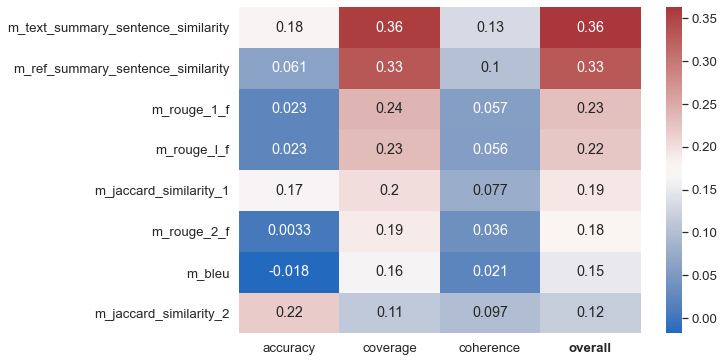

In [4]:
# Plot Heatmap of Target-Feature Correlation
visualize_correlation(
    df_features, 
    df_targets, 
    "overall", 
    None, 
    "figs/axis_metrics_corr",
)

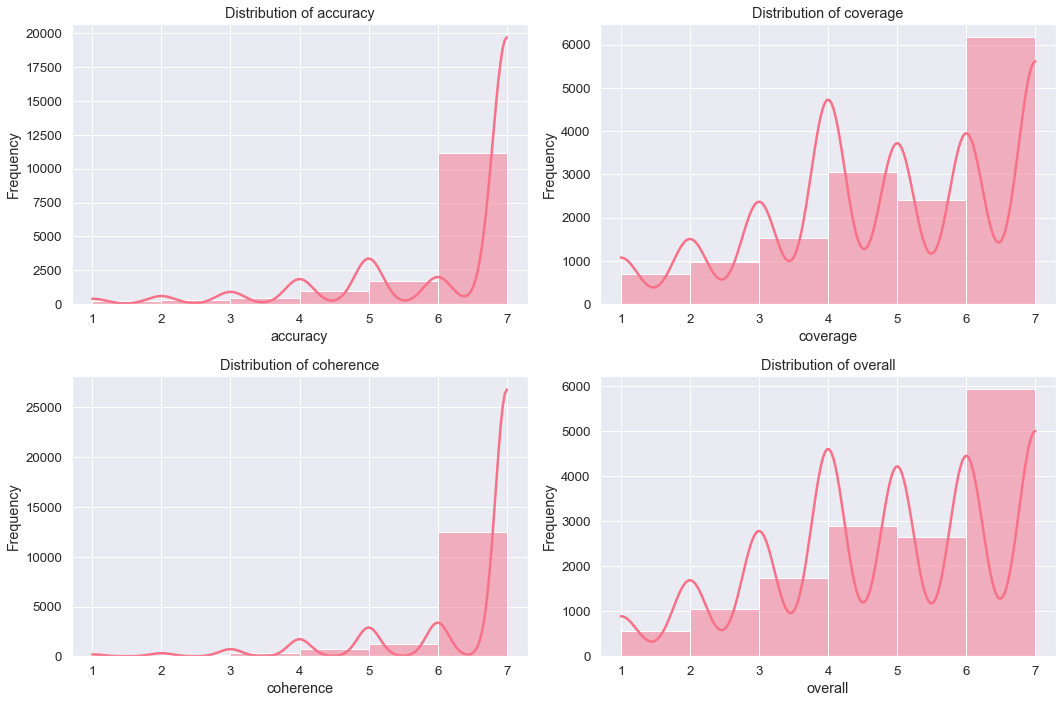

In [5]:
# Visualize the distributions of the Likert scales
visualize_distributions(df_targets, "figs/likert_scales_distribution")